In [1]:
%load_ext autoreload
%autoreload 2
!pwd
import os
import sys 
if os.path.abspath("../../../") not in sys.path:
    sys.path.append(os.path.abspath("../../../")) 

import os
import networkx as nx
from rwtools.nemesis.graph.nemesis_node import AbstractNemesisNode
import matplotlib.pyplot as plt
import os
import matplotlib.image as mpimg
from rwtools.nemesis.control_flow_graph import ControlFlowGraph


In [2]:
import sys 
sys.executable

'/home/gilles/git-repos/NemesisRetroWrite/retrowrite/venv/bin/python'

In [3]:
from test_main import setup 

binary = os.path.abspath("./password_comparison/password_comparison")
outputfile = "./inserted_nodes.s"
loader, rw = setup(binary, outputfile)
rw.dump()

[*] Relocations for a section that's not loaded: .rela.dyn
[x] Could not replace value in .init_array
[x] Couldn't find valid section 3e20
[x] Couldn't find valid section 3fd8
[x] Couldn't find valid section 3fe0
[x] Couldn't find valid section 3fe8
[x] Couldn't find valid section 3ff0
[x] Couldn't find valid section 3ff8


# Learned lesson - Optional nodes
**the problem is that in the initial version the intermediate node (the optional node) jumps to the start of the final node**. This is a problem when you insert additional nodes into the other branch.  
THis is because the other branch will later be inseretd at the start of the final node. So what needs to happen is that the optional node branches to the middle of the final node 

Solution: 
1. insert a branching at the end of the optional node to some newly created label 
2. add this label in the final node BEFORE inserted the newly created node into the final node 


[*] Relocations for a section that's not loaded: .rela.dyn
[x] Could not replace value in .init_array
[x] Couldn't find valid section 3e20
[x] Couldn't find valid section 3fd8
[x] Couldn't find valid section 3fe0
[x] Couldn't find valid section 3fe8
[x] Couldn't find valid section 3ff0
[x] Couldn't find valid section 3ff8


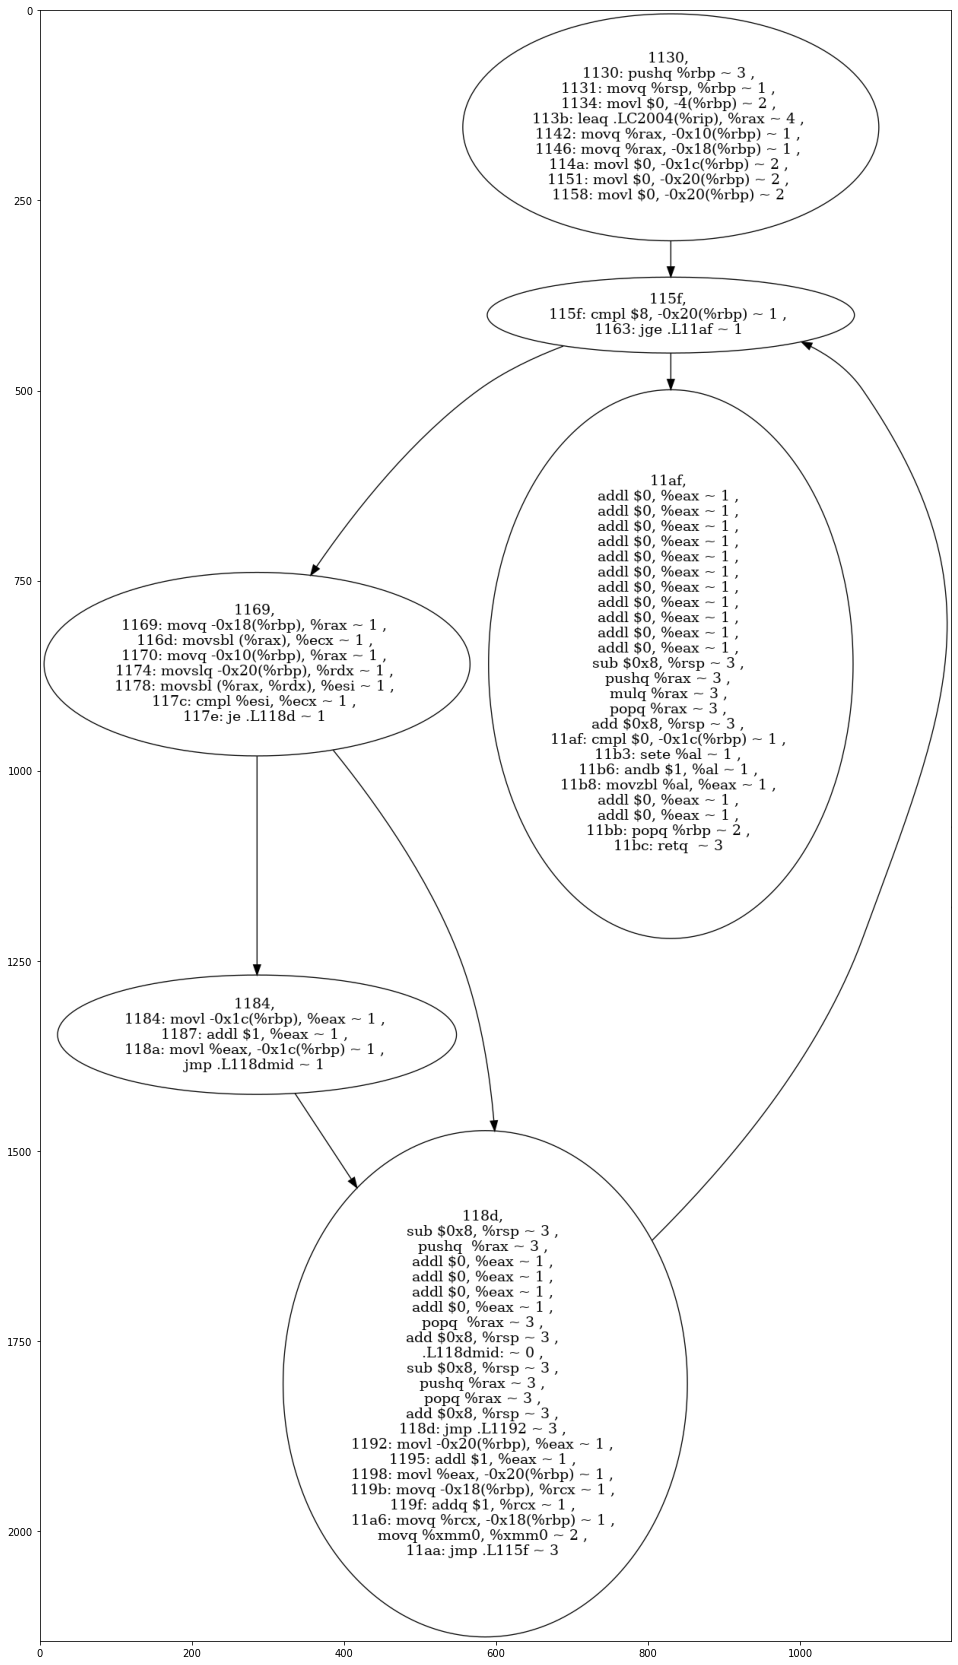

In [5]:

%autoreload 2
from rwtools.nemesis.graph.utils import create_graph_structure
from rwtools.nemesis.graph.utils import to_img
from rwtools.nemesis.graph.balance import balance_branching_point
from rwtools.nemesis.graph.nemesis_node import NemesisNode

outputfile = "./equal_2.s"
loader, rw = setup(binary, outputfile)
function_names = loader.container.function_names
nodes, graph = create_graph_structure(loader.container, "main")
fig, axs = plt.subplots(1, figsize=(30, 30))

control_flow_graph = ControlFlowGraph(nodes=nodes, graph=graph)

control_flow_graph.merge_consecutive_nodes()

control_flow_graph.unwind_graph()

# insert nodes 
control_flow_graph.insert_nodes()

control_flow_graph.equalize_branches()
axs.imshow(to_img(graph))


# # balance 
node = control_flow_graph.get_node('115f')


control_flow_graph.set_stopping_nodes(node)
balance_branching_point(control_flow_graph, node)


control_flow_graph.merge_inserted_nodes()

control_flow_graph.restore_cycles()

# possible problem with instruction addl $0, %eax -- to see if this is the case add push en pop in 118d 
# Without the code below the compiled program has a segfault -- addl $0, %eax does in fact change the program 
# state 
# solution 1: find an alternative that doesn't modify state 
# solution 2: insert push, pop instructions (but in a smarter way so that it doesn't have to be done for each 
# individual addl)
target = control_flow_graph.get_node('118d')
target.insert(0, "sub $0x8, %rsp", 3)
target.insert(1, "pushq  %rax", 3)
target.insert(6, "popq  %rax", 3)
target.insert(7, "add $0x8, %rsp", 3)
axs.imshow(to_img(graph))

rw.dump()

[*] Relocations for a section that's not loaded: .rela.dyn
[x] Could not replace value in .init_array
[x] Couldn't find valid section 3e20
[x] Couldn't find valid section 3fd8
[x] Couldn't find valid section 3fe0
[x] Couldn't find valid section 3fe8
[x] Couldn't find valid section 3ff0
[x] Couldn't find valid section 3ff8
[1, 1, 1, 1, 1, 1, 1]
[]


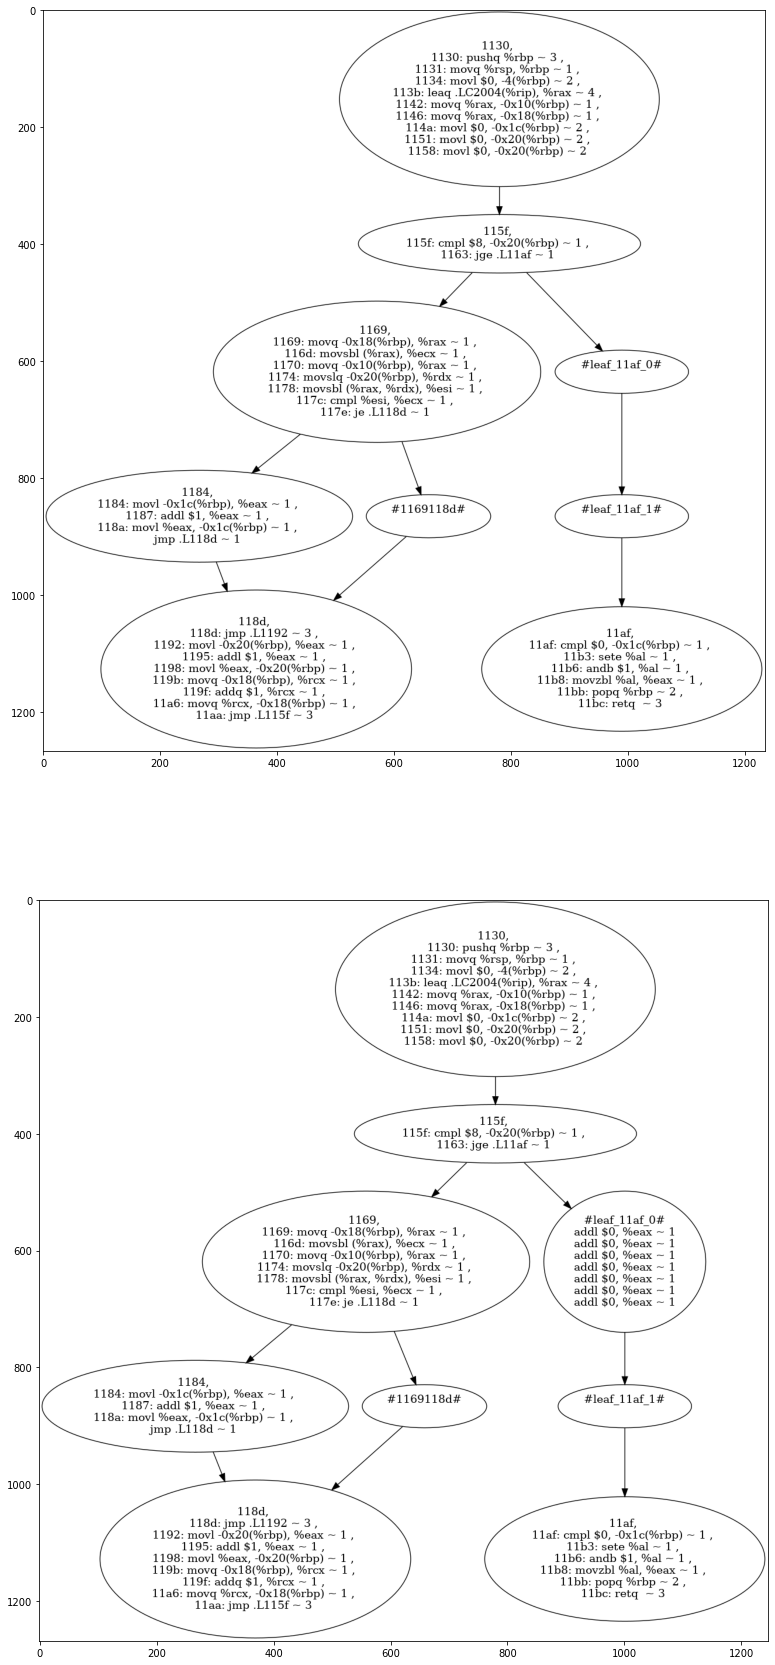

In [18]:

%autoreload 2
from rwtools.nemesis.graph.utils import create_graph_structure
from rwtools.nemesis.graph.utils import to_img
from rwtools.nemesis.graph.balance import balance_branching_point, balance_node_latencies
from rwtools.nemesis.graph.nemesis_node import NemesisNode

outputfile = "./equal_2.s"
loader, rw = setup(binary, outputfile)
function_names = loader.container.function_names
nodes, graph = create_graph_structure(loader.container, "main")
fig, axs = plt.subplots(2, figsize=(30, 30))

control_flow_graph = ControlFlowGraph(nodes=nodes, graph=graph)

control_flow_graph.merge_consecutive_nodes()

control_flow_graph.unwind_graph()

# insert nodes 
control_flow_graph.insert_nodes()

control_flow_graph.equalize_branches()
axs[0].imshow(to_img(graph))


# # balance 
node = control_flow_graph.get_node('115f')


node_a = control_flow_graph.get_node('1169')
node_b = control_flow_graph.get_node('leaf_11af_0')

balance_node_latencies(node_a, node_b)
axs[1].imshow(to_img(graph))


In [19]:
node_a_latencies = [1,2, 3]
node_b_latencies = [3, 4, 5]


# various stages of the balancing algorithm 
1. determine a target latency list (not taking into account state)   
2. determine where push and pop instructions need to be added (to store state)   
3. determine where push and pop instrucions need to be added to take into account other pops and pushes   
4. determine where add, subtract instructions need to be added   

dit werkt mogelijsk wel voor 2 nodes, maar wat als er 3 of 4 of meer zijn? 

Eigenlijk moet de locaties van de pushes en de pops fluide zijn 

Of voeg die pas helemaal op het einde toe? Doorheen process markers bijhouden van waar die mogelijks zouden moeten komen 

Of pas ze allesinds aan

Balancing recursively is eigenlijk hetzelfde als level by level 

Voorstel: 
balance insructions without taking into account state, insert push and pop instructions after the facts to account for this.  
Remove instrumented push and pop instructions, where needed. Problem -- dan ben ik wel push en pop instructions aan het toevoegen en weer aan het verwijderen 

Oplossing -- balance recursively. At the end of the balancing step, determine where to insert what push and pop instructions -- keep track per node of which registers where modified by which nodes and where in the node 

Take into account that a push has to occur at the same moment for al nodes at a given depth 


# Push and pop -- points of interests
These are points where a push and/or pop has to occur 
1. PUSH - before instrumented instructions that modify a register
2. POP - before instruction that uses the modified register 

# Proposed algorithm (for inserting instructions) 
First balance the entire algorithm as if there are no changes to the state. 
Then all the way at the end, go level by level and insert push and pop instructions where needed. 
Formally determine where this is 
